In [1]:
import networkx as nx
from networkx.readwrite import graphml
from math import *
import networkx as nx
import math
import csv
from statistics import mean

In [2]:
import itertools

parallel_links=2


def segments_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
    """
    Determine if two line segments intersect, given their endpoints (x1, y1), (x2, y2) and (x3, y3), (x4, y4).
    """
    # calculate the direction vectors for each segment
    dx1 = x2 - x1
    dy1 = y2 - y1
    dx2 = x4 - x3
    dy2 = y4 - y3

    # calculate the determinant
    det = dx1*dy2 - dx2*dy1

    # check if the determinant is zero
    if det == 0:
        return False

    # calculate the inverse determinant
    inv_det = 1 / det

    # calculate the difference vectors for each segment
    dx3 = x1 - x3
    dy3 = y1 - y3

    # calculate the parameters of the intersection point
    t1 = (dx2*dy3 - dx3*dy2) * inv_det
    t2 = (dx1*dy3 - dx3*dy1) * inv_det

    # check if the intersection point lies within both segments
    if 0 < t1 < 1 and 0 < t2 < 1:
        return True
    else:
        return False


def count_edge_crossings(G):
    """
    Count the number of edge crossings on each edge in G
    """

    crossings = {}

    for edge in G.edges():
        crossings[edge] = 0
        for other_edge in G.edges():
            if edge[0]!=other_edge[0] and edge[0]!=other_edge[1] and edge[1]!=other_edge[0] and edge[1]!=other_edge[1]:
                if segments_intersect(*pos[edge[0]], *pos[edge[1]], *pos[other_edge[0]], *pos[other_edge[1]]):
                    crossings[edge] += parallel_links

    return crossings


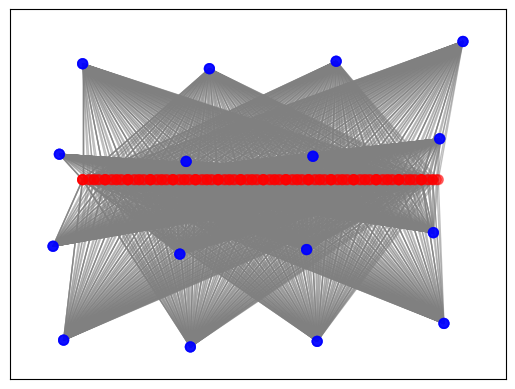

In [3]:

# Specify the file name
file_name = 'straight_crossing_config2.csv'

# Write data to CSV file
with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    data =  ['N', 'Theta[GBps]', 'ave_crossing_per_wg']
    writer.writerow(data)
    
    # bw_list = [960]
    bw_list = [1024, 1024*2, 1024*3, 1024*4]
    num_chips = 16
    bw_per_sw=16*4 #GBps
    for bw in bw_list:
        num_switches = bw // bw_per_sw

        # Create graph
        G = nx.empty_graph(num_chips)
        labels = {i: str(i) for i in range(num_chips)}
        nx.set_node_attributes(G, labels, 'label')

        subset_dict = {}
        for i in range(num_chips):
            subset_dict[i] = i // math.sqrt(num_chips)

        # Add the subset information to the graph
        nx.set_node_attributes(G, subset_dict, 'subset')

        pos = nx.multipartite_layout(G)
        shift = 0.1  # set the shift amount for the x-axis
        for n in pos:
            pos[n][0] += (pos[n][1])*(pos[n][1]+0.5) * shift
            pos[n][1] += (pos[n][0])*(pos[n][0]+0.5) * shift


        last_vertex_second_row = pos[0][1]
        first_vertex_third_row = pos[len(pos)-1][1]
        new_row_y_1 = 0.1+(last_vertex_second_row + first_vertex_third_row) / 2
        additional_vertices = range(num_chips, num_chips + num_switches)
        labels_additional = {i: str(i) for i in additional_vertices}
        nx.set_node_attributes(G, labels_additional, 'label')
        # Update the position dictionary with the new row's positions
        x_min = pos[0][0]
        x_max = pos[15][0]
        for i, vertex in enumerate(additional_vertices):
            pos[vertex] = [x_min+i*(x_max-x_min)/num_switches, new_row_y_1]
        # Add the additional vertices to the graph
        G.add_nodes_from(additional_vertices)
        # Add edges between the additional row and the original grid vertices
        G.add_edges_from([(vertex, original_vertex) for vertex in additional_vertices for original_vertex in range(num_chips)])

        # Draw the updated graph with different node colors
        node_colors = ['blue'] * num_chips + ['red'] * num_switches

        # Draw the updated graph
        nx.draw_networkx(G, pos=pos, with_labels=False, node_size=50, alpha=0.5, edge_color='gray', node_color=node_colors)

        crossings = count_edge_crossings(G)
        values = list(crossings.values())
        average_crossings = mean(values)

        data =  [16, bw, average_crossings]
        writer.writerow(data)
